In [2]:
import librosa
import scipy
import os
import numpy as np
import matplotlib.pyplot as plt

from notebook_utils import get_audio_list

In [3]:
#constantes
RIR_PATH = '/home/mrtn/Documents/TESIS/de-reverb/bases de datos/data/impulsos'
SPEECH_PATH = '/home/mrtn/Documents/TESIS/de-reverb/bases de datos/data/speech/train-clean-100'
SAVE_PATH='/home/mrtn/Documents/TESIS/de-reverb/nuevo_modelo/npy_data/'
Q_e = 32
LM = 5
Pd = 9

In [4]:
rir_list = get_audio_list(RIR_PATH)
speech_list = get_audio_list(SPEECH_PATH)

In [5]:
#generar espectrogramas de mismas dimenciones
rir, fs_rir = librosa.load(rir_list[0], sr=16000)
speech, fs_speech = librosa.load(speech_list[0], sr=16000)
assert fs_rir == fs_speech

#Corto el delay y normalizo el impulso
rir = rir[np.argmax(abs(rir)):]/rir[np.argmax(abs(rir))]
rir_early = rir[:Q_e]

#Convoluciono y limito al largo del speech
reverb = scipy.signal.fftconvolve(speech, rir)[:len(speech)]
early_reverb = scipy.signal.fftconvolve(speech, rir_early)[:len(speech)]

#Calculos los espectro STFT y me quedo con el modulo
reverb_spec = librosa.stft(reverb, n_fft=512, hop_length=160, win_length=400, window=scipy.signal.windows.hamming)
early_reverb_spec = librosa.stft(early_reverb, n_fft=512, hop_length=160, win_length=400, window=scipy.signal.windows.hamming)
assert reverb_spec.shape == early_reverb_spec.shape
reverb_spec = abs(reverb_spec)
early_reverb_spec = abs(early_reverb_spec)

#Normalizacion(?)

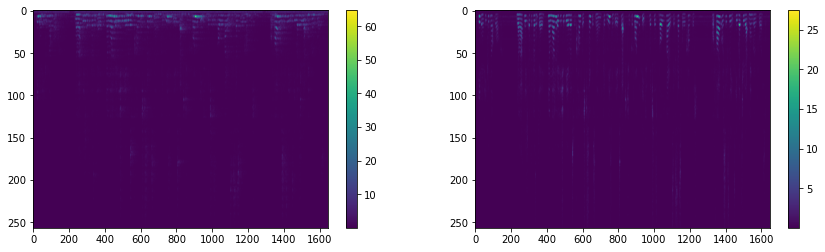

In [6]:
plt.subplot(1,2,1)
plt.imshow(reverb_spec, aspect='auto')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(early_reverb_spec, aspect='auto')
plt.colorbar()
plt.subplots_adjust(right=2)

Para determinar si hacer o no y donde hacer la normalizacion, puedo dejar para hacerlo en el data loader, que es el ultimo paso antes de entrar a la red. Por lo que dice el paper, la input A (que entra a la red) se le deberia calcular el LPS y al resto solo se deberia trabajar con el modulo del espectrograma complejo, como se ven en las imagenes de aca arriba.

In [7]:
#formacion de las imputs
n_frames = np.arange(reverb_spec.shape[1])
valid_frames = n_frames[Pd-1:int(-((LM-1)/2)-1)]

# input_A ---> Lo que entra a la red
# input B ---> time-shifted para convolucion final
# output  ---> frame objetivo del espectro early
inputs_A = []
inputs_B = []
outputs = []
for l in valid_frames:
    input_A = reverb_spec[:, int(l-((LM-1)/2)):int(l+((LM-1)/2)+1)]
    input_B = reverb_spec[:, l-Pd+1:l+1]
    output = early_reverb_spec[:, l]
    inputs_A.append(input_A)
    inputs_B.append(input_B)
    outputs.append(output)

In [8]:
def generate_specs(rir, speech):
    #Corto el delay y normalizo el impulso
    rir = rir[np.argmax(abs(rir)):]/rir[np.argmax(abs(rir))]
    rir_early = rir[:Q_e]

    #Convoluciono y limito al largo del speech
    reverb = scipy.signal.fftconvolve(speech, rir)[:len(speech)]
    early_reverb = scipy.signal.fftconvolve(speech, rir_early)[:len(speech)]

    #Calculos los espectro STFT y me quedo con el modulo
    reverb_spec = librosa.stft(reverb, n_fft=512, hop_length=160, win_length=400, window=scipy.signal.windows.hamming)
    early_reverb_spec = librosa.stft(early_reverb, n_fft=512, hop_length=160, win_length=400, window=scipy.signal.windows.hamming)
    assert reverb_spec.shape == early_reverb_spec.shape
    reverb_spec = abs(reverb_spec)
    early_reverb_spec = abs(early_reverb_spec)

    #Normalizacion(?)
    return reverb_spec, early_reverb_spec
    
def generate_inputs(reverb_spec, early_reverb_spec, contador, path):
    n_frames = np.arange(reverb_spec.shape[1])
    valid_frames = n_frames[Pd-1:int(-((LM-1)/2)-1)]
    for l in valid_frames:
        input_A = reverb_spec[:, int(l-((LM-1)/2)):int(l+((LM-1)/2)+1)]
        input_B = reverb_spec[:, l-Pd+1:l+1]
        output = early_reverb_spec[:, l]
        save_path = os.path.join(path, str(contador)+'.npy')
        save_arrays = [input_A, input_B, output]
        final_array = np.empty(len(save_arrays), dtype='object')
        final_array[:] = save_arrays
        np.save(save_path, final_array)
        contador +=160

In [9]:
#Pipeline para un solo par de speech-rir
contador = 0
reverb_spec, early_reverb_spec = generate_specs(rir, speech)
generate_inputs(reverb_spec, early_reverb_spec, contador, SAVE_PATH)

In [13]:
np.load(SAVE_PATH+'1.npy', allow_pickle=True)

array([array([[1.6164138e+00, 2.6453894e-01, 2.9590635e+00, 8.6668861e-01,
        2.3322294e+00],
       [3.6437693e+00, 2.6247730e+00, 3.9721835e+00, 2.6198134e+00,
        3.5368288e+00],
       [4.4448781e+00, 4.0239286e+00, 3.8832765e+00, 2.9672439e+00,
        3.6352344e+00],
       ...,
       [2.7242061e-03, 2.8288125e-03, 1.9098213e-03, 6.4851088e-03,
        2.8174603e-03],
       [4.2542312e-03, 4.2819610e-04, 6.3725613e-04, 3.6673972e-03,
        3.1482871e-03],
       [5.0047092e-04, 3.1311228e-03, 1.8487744e-04, 1.7493898e-03,
        1.2491138e-03]], dtype=float32),
       array([[2.1806331e+00, 1.0711604e+00, 4.8133087e+00, ..., 1.6164138e+00,
        2.6453894e-01, 2.9590635e+00],
       [3.0908854e+00, 3.2758505e+00, 5.6532741e+00, ..., 3.6437693e+00,
        2.6247730e+00, 3.9721835e+00],
       [2.9923134e+00, 4.0571651e+00, 4.7807193e+00, ..., 4.4448781e+00,
        4.0239286e+00, 3.8832765e+00],
       ...,
       [3.6815114e-03, 4.0805591e-03, 2.5398177e-03, ...,